In [1]:
#python specific stuff
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from functions import *
from ReadInParameters import *

##TODO Lizzy
#variable time step? check convergence somehow? Runge kutta method
#optimize run time
#different types of windows
#initial = external temp
#internals - end cell no heat loss
#underfloor heating
#hot spot with fixed temp (or ratio of temp to water system temp??)

#FOR DAD
# Check material values
# how to do windows double glazing
# make Qin model for different types of heating


# TO RUN ONE CELL ONLY = Shift+Enter

In [2]:
## INITIALIZATION for time, and distance step?
total_time_h=2 #hours
t_step=1 #s
total_time_s=total_time_h*60*60
N_t_steps=int(total_time_s/t_step)+1
t_array=np.arange(0,N_t_steps*t_step,t_step)/(60*60) #time array in hours

C:\Users\EH842\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


13


100%|██████████| 7201/7201 [00:29<00:00, 242.29it/s]


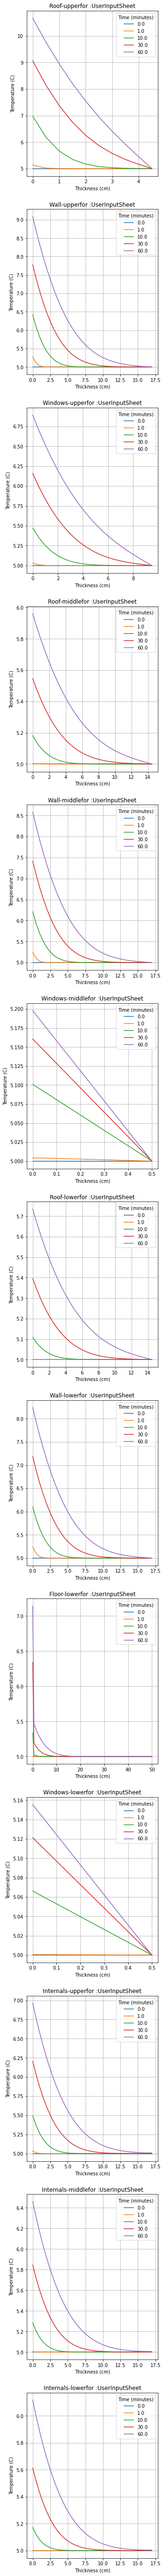

In [3]:
# # UPPER ROOM INITIALIZATION #########################
Data_input_spreadsheet='UserInputSheet'
#Data_input_spreadsheet=input("spreadsheet name:  ")
[rooms,surfaces,T_target,T_exterior,hotspots,internals]=ReadInParameters(Data_input_spreadsheet+ '.xlsx')
upper=rooms[0]
middle=rooms[1]
lower=rooms[2]
surface_array_upper=surfaces[0]
surface_array_middle=surfaces[1]
surface_array_lower=surfaces[2]
no_surfaces=np.size(surface_array_upper+surface_array_middle+surface_array_lower+internals)
print(no_surfaces)
surface_name_list=['Roof-upper','Wall-upper','Windows-upper','Roof-middle','Wall-middle','Windows-middle','Roof-lower','Wall-lower','Floor-lower','Windows-lower','Internals-upper','Internals-middle','Internals-lower']


## USER INPUTS
# when to visualize wall temperatures
t_visualization=np.array([0,1,10,30,1*60,5*60])*60 #times to show wall internal temp in seconds
t_turnoff=1*60*60 #turn of time in s


## DO CALCULATION ##################

data_array_T_room_upper=np.zeros(int(N_t_steps))
data_array_T_room_middle=np.zeros(int(N_t_steps))
data_array_T_room_lower=np.zeros(int(N_t_steps))
data_array_T_feelslike=np.zeros(int(N_t_steps))
Qs=np.zeros(int(N_t_steps))
data_array_surfaces=np.zeros([int(N_t_steps),no_surfaces])
data_array_surfaces_Q=np.zeros([int(N_t_steps),no_surfaces])
data_array_hotspots=np.zeros([int(N_t_steps),3])
data_array_hotspots_Q=np.zeros([int(N_t_steps),3])
Qin_cumul=[0]

fig, (axs) = plt.subplots(no_surfaces,1,figsize=(5, 100))
for t in tqdm(range(N_t_steps)):
    
    #input data into arrays for plotting
    data_array_T_room_upper[t]=upper.T_room
    data_array_T_room_middle[t]=middle.T_room
    data_array_T_room_lower[t]=lower.T_room
    
    
    data_array=[]  
    surface_contribution_to_temperature=0
    surface_area_sum=0
    for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            data_array=np.append(data_array,surface.T_array[0])
            surface_contribution_to_temperature=surface_contribution_to_temperature+surface.T_array[0]*surface.area
            surface_area_sum=surface_area_sum+surface.area
    data_array_surfaces[t,:]=data_array
    
    data_array_T_feelslike[t]=0.5*lower.T_room+0.5*(surface_contribution_to_temperature/surface_area_sum)
    
    data_array=[]  
    for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            data_array=np.append(data_array,surface.Qout_array[0])            
    data_array_surfaces_Q[t,:]=data_array
    
    
    data_array=[]
    data_array_hotspot=[]
    for hotspot in hotspots:
            data_array=np.append(data_array,hotspot.T_array[0])            
    data_array_hotspots[t,:]=data_array

    if t in t_visualization/t_step:
        s=0
        for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            lineObjects =axs[s].plot(np.arange(0,surface.N_cells*0.5,0.5),surface.T_array)
            axs[s].legend(t_visualization/60,title='Time (minutes)')
            axs[s].grid('True')
            axs[s].set_title(surface_name_list[s] + 'for :' + Data_input_spreadsheet)
            axs[s].set_xlabel('Thickness (cm)')
            axs[s].set_ylabel('Temperature (C)')
            s=s+1
    
    #heating ON/OFF
    
    Qin_total=0
    if lower.T_room >= T_target or t > t_turnoff/t_step:
        upper.Qin=0
        middle.Qin=0
        lower.Qin=0
        for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            surface.Qrad=0
        Qout_room_to_hotspot_upper=0
        Qout_room_to_hotspot_middle=0
        Qout_room_to_hotspot_lower=0
    else:
        upper.Qin=upper.Qin_max
        middle.Qin=middle.Qin_max
        lower.Qin=lower.Qin_max
        Qin_total=Qin_total+upper.Qin+middle.Qin+lower.Qin
        for surface in surface_array_upper+surface_array_middle+surface_array_lower+internals:
            surface.Qrad=surface.Qrad_max
            Qin_total=Qin_total+surface.Qrad
        Qout_room_to_hotspot_upper=do_hotspots_in_room(hotspots[0],t_step,T_exterior)
        Qout_room_to_hotspot_middle=do_hotspots_in_room(hotspots[1],t_step,T_exterior)
        Qout_room_to_hotspot_lower=do_hotspots_in_room(hotspots[2],t_step,T_exterior)
    
    data_array=[]# for hotspots
    ## LAYER UPPER
    [Qout_room_total,surface_array_upper]=do_surfaces_in_room(surface_array_upper,upper.T_room,t_step,T_exterior)
    #Qout_room_to_hotspot_upper=do_hotspots_in_room(hotspots[0],t_step,T_exterior)
    data_array=np.append(data_array,Qout_room_to_hotspot_upper)  
    [Qout_room_to_internals,internals[0]]=do_internals_in_room(internals[0],upper.T_room,t_step,T_exterior)
    Qout_upper_to_middle=calculate_Qout_convective(upper.U,upper.area,upper.T_room,middle.T_room)
    Q_leak_upper=upper.airchanges_per_hour*upper.volume*t_step*upper.densityC*(upper.T_room-T_exterior)/3600
    Qout_room_total=Qout_room_total+Qout_upper_to_middle+Qout_room_to_internals+Qout_room_to_hotspot_upper+Q_leak_upper
    upper.T_room=upper.T_room+calculate_Tchange(upper.Qin,Qout_room_total,t_step,upper.densityC,upper.volume)
    
    ## LAYER MIDDLE
    [Qout_room_total,surface_array_middle]=do_surfaces_in_room(surface_array_middle,middle.T_room,t_step,T_exterior)
    #Qout_room_to_hotspot_middle=do_hotspots_in_room(hotspots[1],t_step,T_exterior)
    data_array=np.append(data_array,Qout_room_to_hotspot_middle) 
    [Qout_room_to_internals,internals[1]]=do_internals_in_room(internals[1],middle.T_room,t_step,T_exterior)
    Qout_middle_to_lower=calculate_Qout_convective(middle.U,middle.area,middle.T_room,lower.T_room)
    Q_leak_middle=middle.airchanges_per_hour*middle.volume*t_step*middle.densityC*(middle.T_room-T_exterior)/3600
    Qout_room_total=Qout_room_total+Qout_middle_to_lower+Qout_room_to_internals+Qout_room_to_hotspot_middle+Q_leak_middle
    middle.T_room=middle.T_room+calculate_Tchange(middle.Qin+Qout_upper_to_middle,Qout_room_total,t_step,middle.densityC,middle.volume)
    
    ## LAYER LOWER
    [Qout_room_total,surface_array_lower]=do_surfaces_in_room(surface_array_lower,lower.T_room,t_step,T_exterior)
    #Qout_room_to_hotspot_lower=do_hotspots_in_room(hotspots[2],t_step,T_exterior)
    data_array=np.append(data_array,Qout_room_to_hotspot_lower) 
    [Qout_room_to_internals,internals[2]]=do_internals_in_room(internals[2],lower.T_room,t_step,T_exterior)
    Q_leak_lower=lower.airchanges_per_hour*lower.volume*t_step*lower.densityC*(lower.T_room-T_exterior)/3600
    Qout_room_total=Qout_room_total+ Qout_room_to_internals+Qout_room_to_hotspot_lower+Q_leak_lower
    lower.T_room=lower.T_room+calculate_Tchange(lower.Qin+Qout_middle_to_lower,Qout_room_total,t_step,lower.densityC,lower.volume)
    
    data_array_hotspots_Q[t,:]=data_array
    
    ## CUMUL Q
    Qin_cumul=np.append(Qin_cumul,Qin_cumul[t]+Qin_total*t_step)  

6.290028537120058


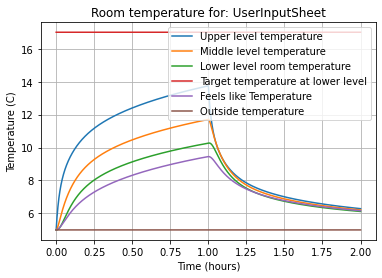

In [4]:
# MAKE PLOTS ##########################
plt.plot(t_array,data_array_T_room_upper,label='Upper level temperature')
plt.plot(t_array,data_array_T_room_middle,label='Middle level temperature')
plt.plot(t_array,data_array_T_room_lower,label='Lower level room temperature')
plt.plot(t_array,np.full(N_t_steps,T_target),label='Target temperature at lower level')
plt.plot(t_array,data_array_T_feelslike,label='Feels like Temperature')
plt.plot(t_array,np.full(N_t_steps,T_exterior),label='Outside temperature')
plt.title('Room temperature for: ' + Data_input_spreadsheet)
plt.legend()
plt.grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')
print(data_array_T_room_upper[-1])

Text(0, 0.5, 'Temperature (C)')

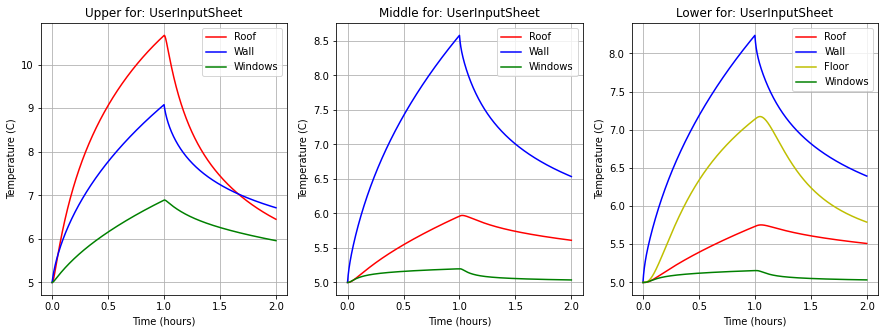

In [5]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
lineObjects =ax1.plot(t_array,data_array_surfaces[:,0:1],'r',t_array,data_array_surfaces[:,1:2],'b',t_array,data_array_surfaces[:,2:3],'g')
ax1.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax1.grid('True')
ax1.set_title('Upper for: ' + Data_input_spreadsheet)
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (C)')
lineObjects =ax2.plot(t_array,data_array_surfaces[:,3:4],'r',t_array,data_array_surfaces[:,4:5],'b',t_array,data_array_surfaces[:,5:6],'g')
ax2.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax2.set_title('Middle for: ' + Data_input_spreadsheet)
ax2.grid('True')
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Temperature (C)')
lineObjects =ax3.plot(t_array,data_array_surfaces[:,6:7],'r',t_array,data_array_surfaces[:,7:8],'b',t_array,data_array_surfaces[:,8:9],'y',t_array,data_array_surfaces[:,9:10],'g')
ax3.legend(iter(lineObjects), ('Roof','Wall','Floor','Windows'))
ax3.set_title('Lower for: ' + Data_input_spreadsheet)
ax3.grid('True')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('Temperature (C)')

Text(0, 0.5, 'Temperature (C)')

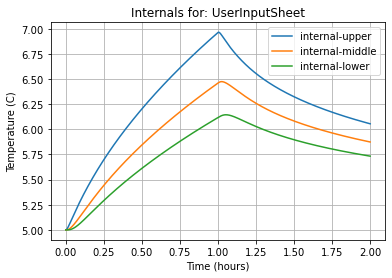

In [6]:
lineObjects =plt.plot(t_array,data_array_surfaces[:,10:13])
plt.legend(iter(lineObjects), ('internal-upper','internal-middle','internal-lower'))
plt.grid('True')
plt.title('Internals for: ' + Data_input_spreadsheet)
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')

Text(0, 0.5, 'Temperature (C)')

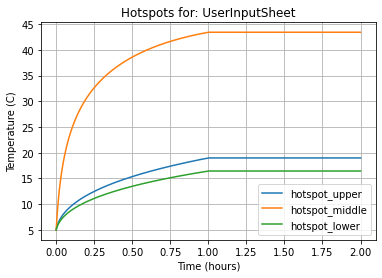

In [7]:
lineObjects =plt.plot(t_array,data_array_hotspots)
plt.legend(iter(lineObjects), ('hotspot_upper','hotspot_middle','hotspot_lower'))
plt.title('Hotspots for: ' + Data_input_spreadsheet)
plt.grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (C)')

Text(0, 0.5, 'Heat provided (Joules)')

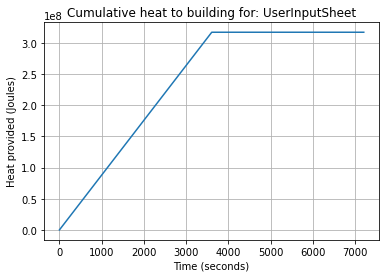

In [8]:
plt.plot(Qin_cumul)
plt.title('Cumulative heat to building for: ' + Data_input_spreadsheet)
plt.grid('True')
plt.xlabel('Time (seconds)')
plt.ylabel('Heat provided (Joules)')

Text(0, 0.5, 'Heat to surface (W)')

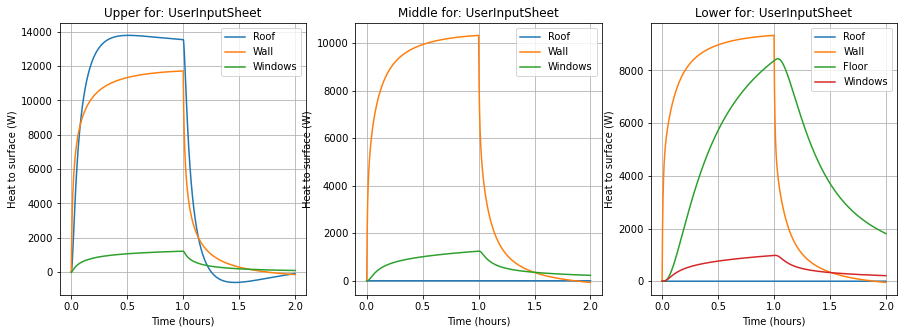

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
lineObjects =ax1.plot(t_array,data_array_surfaces_Q[:,0:3])
ax1.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax1.grid('True')
ax1.set_title('Upper for: ' + Data_input_spreadsheet)
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Heat to surface (W)')
lineObjects =ax2.plot(t_array,data_array_surfaces_Q[:,3:6])
ax2.legend(iter(lineObjects), ('Roof','Wall','Windows'))
ax2.set_title('Middle for: ' + Data_input_spreadsheet)
ax2.grid('True')
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Heat to surface (W)')
lineObjects =ax3.plot(t_array,data_array_surfaces_Q[:,6:10])
ax3.legend(iter(lineObjects), ('Roof','Wall','Floor','Windows'))
ax3.set_title('Lower for: ' + Data_input_spreadsheet)
ax3.grid('True')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('Heat to surface (W)')

Text(0, 0.5, 'Heat to surface (W)')

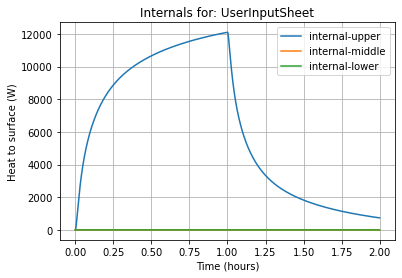

In [10]:
lineObjects =plt.plot(t_array,data_array_surfaces_Q[:,10:13])
plt.legend(iter(lineObjects), ('internal-upper','internal-middle','internal-lower'))
plt.grid('True')
plt.title('Internals for: ' + Data_input_spreadsheet)
plt.xlabel('Time (hours)')
plt.ylabel('Heat to surface (W)')

Text(0, 0.5, 'Heat to surface (W)')

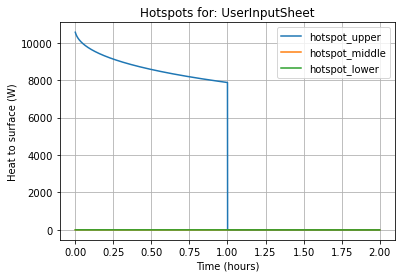

In [11]:
lineObjects =plt.plot(t_array,data_array_hotspots_Q)
plt.legend(iter(lineObjects), ('hotspot_upper','hotspot_middle','hotspot_lower'))
plt.title('Hotspots for: ' + Data_input_spreadsheet)
plt.grid('True')
plt.xlabel('Time (hours)')
plt.ylabel('Heat to surface (W)')